In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [2]:
drowsy_path = "Driver Drowsiness Dataset (DDD)/Drowsy"
non_drowsy_path = "Driver Drowsiness Dataset (DDD)/Non Drowsy"

def count_images(directory):
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif') 
    return sum(1 for filename in os.listdir(directory) if filename.lower().endswith(image_extensions))

# Count images in each directory
drowsy_count = count_images(drowsy_path)
non_drowsy_count = count_images(non_drowsy_path)

print(f"Number of images in Drowsy: {drowsy_count}")
print(f"Number of images in Non Drowsy: {non_drowsy_count}")


Number of images in Drowsy: 22348
Number of images in Non Drowsy: 19445


In [15]:
# Function to plot a grid of image samples
def plot_image_samples(directory, num_samples=4):
    image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
    
    # Select the first 'num_samples' images
    image_files = image_files[:num_samples]
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, img_file in enumerate(image_files):
        # Load image
        img = mpimg.imread(os.path.join(directory, img_file))
        
        # Plot image
        axes[i].imshow(img)
        axes[i].set_title(f"Image example {i+1}")
        axes[i].axis('off')  # Hide axis
    
    plt.tight_layout()
    plt.show()

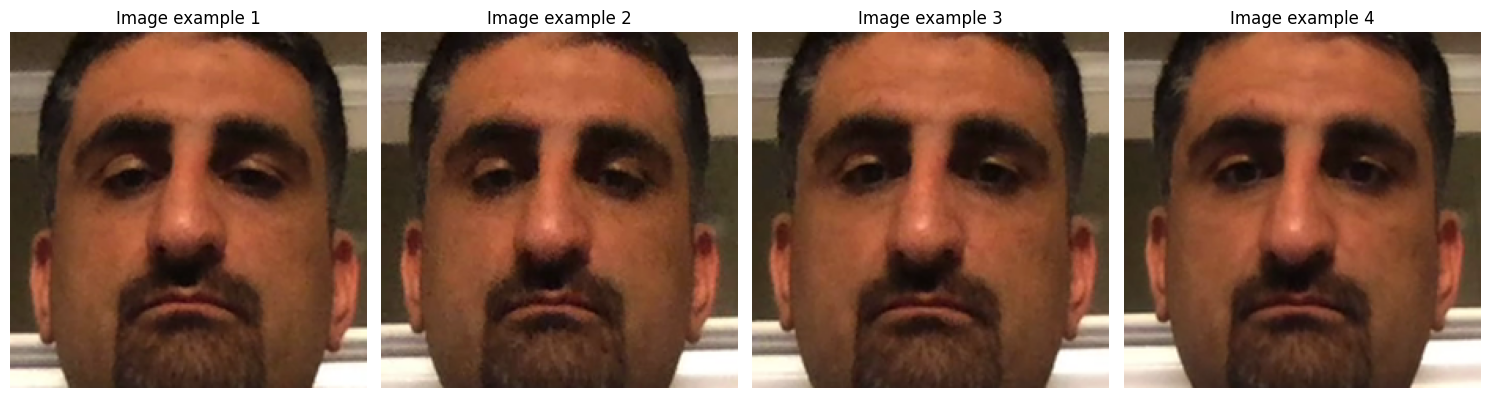

In [16]:
plot_image_samples(drowsy_path)

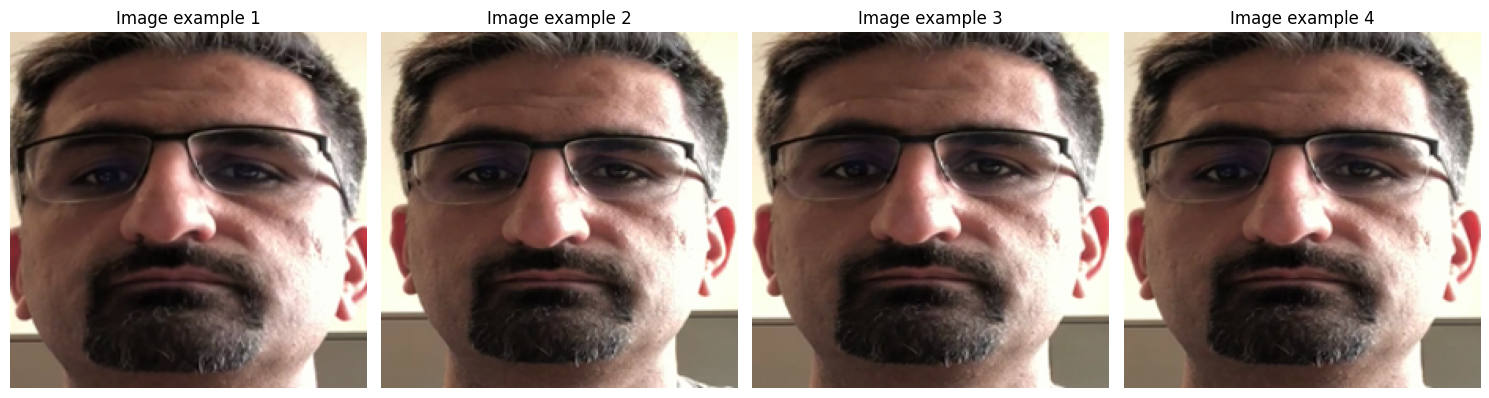

In [17]:
plot_image_samples(non_drowsy_path)

1. Resizing
2. Greyscale conversion
3. Noise reduction
4. Data augmentation (if needed)
5. Normalization (scaling pixel)
6. Image enhancement (if needed)
7. Feature extraction

In [ ]:
import splitfolders

#Define paths
input_path = "Driver Drowsiness Dataset (DDD)"
output_path = "Dataset_split"

# Split the dataset
splitfolders.ratio(
    input_path,
    output=output_path,
    seed=42,
    ratio=(0.7,0.15,0.15),
    group_prefix=None,
    move=False
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
import numpy as np
import cv2
import tensorflow as tf


# Define paths
train_dir = 'Dataset_split/train'
test_dir = 'Dataset_split/test'
val_dir = 'Dataset_split/val'


# Preprocessing function
def preprocess_function(img):
    # Convert to numpy array for OpenCV
    img_array = img.astype('uint8')
    # Apply Gaussian blur for noise reduction
    img_array = cv2.GaussianBlur(img_array, (5, 5), 0)
    # Normalize the image to 0-1
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=-1)
    return img_array

# Initiate data generators with the custom preprocessing function
train_data_gen = ImageDataGenerator(preprocessing_function=preprocess_function)
val_data_gen = ImageDataGenerator(preprocessing_function=preprocess_function)
test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_function)

# Create the generators
train_generator = train_data_gen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    color_mode='grayscale', 
    class_mode='binary'  
)

val_generator = val_data_gen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=32,
    color_mode='grayscale',
    class_mode='binary'
)

test_generator = test_data_gen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    color_mode='grayscale',
    class_mode='binary'
)


for data_batch, labels_batch in train_generator:
    print("Batch of data shape:", data_batch.shape)
    print("Batch of labels shape:", labels_batch.shape)
    break  

In [ ]:
import matplotlib.pyplot as plt

for data_batch, labels_batch in train_generator:
    print("Batch of data shape:", data_batch.shape)
    print("Batch of labels shape:", labels_batch.shape)
    
    # Display a few images from the batch
    num_images_to_display = 5
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images_to_display):
        ax = plt.subplot(1, num_images_to_display, i + 1)
        plt.imshow(data_batch[i].squeeze(), cmap='gray')
        plt.title(f"Label: {int(labels_batch[i])}")
        plt.axis("off")
    
    plt.show()
    break

# lable 1 = non drowsy
# label 0 = drowsy